# IS 4487 Lab 10

## Outline

Repeat exercises from Lab 9, but with the *Air Quality Daily AQI* dataset.

Pull the latest "Daily AQI by County" file from this link: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI

Your target variable is *CATEGORY*, indicating if the air is healthy.  You can focus on either the entire country, split the country in regions, or focus on just one area (ex. Utah).   You can reduce noise by aggregating the data to the month of season level.   

Can you predict the category based on the location and time of year?  

The AQI is divided into six categories:

*Air Quality Index*

|(AQI) Values	|Levels of Health Concern	        |
|---------------|--------|
|0-50	        |Good	 |
|51-100	        |Moderate	 |
|101-150	    |Unhealthy for Sensitive Groups	|
|151 to 200	    |Unhealthy	 |
|201 to 300	    |Very Unhealthy	 |
|301 to 500	    |Hazardous	 |

<a href="https://colab.research.google.com/github/Stan-Pugsley/is_4487_base/blob/main/Labs/Scripts/lab10_air_quality_fit_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load Libraries

➡️ Assignment Tasks
- Load any necessary libraries

In [8]:
import pandas as pd
import matplotlib as mpl
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

## Import Data into Dataframe

➡️ Assignment Tasks
- Import data from the air quality dataset into a dataframe (in GitHub go to Labs > DataSets)
- Describe or profile the dataframe

In [5]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

df = pd.read_csv (r'/content/gdrive/MyDrive/Colab Notebooks/daily_aqi_by_county_2023.csv')

Mounted at /content/gdrive


## Prepare Data

➡️ Assignment Tasks
- Create one dummy variable (true/false) for each of the Defining Parameter values    
- Create variables for month and season
- Perform any other data cleanup needed (remove outliers, nulls, etc.)
- Select the data you would like to use in the model.  If you aggregate data, you will have to decide whether to use the min, max or mean value for AQI

In [6]:
#create columns
# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Create month and season variables
df['Month'] = df['Date'].dt.month
df['Season'] = df['Month'].apply(lambda x: (x%12 + 3)//3)

# Map months to seasons: 1 = Winter, 2 = Spring, 3 = Summer, 4 = Fall
seasons = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
df['Season'] = df['Season'].map(seasons)

# Create dummy variables for AQI categories
df['Good'] = df['AQI'].apply(lambda x: x <= 50)
df['Moderate'] = df['AQI'].apply(lambda x: 51 <= x <= 100)
df['Unhealthy for Sensitive Groups'] = df['AQI'].apply(lambda x: 101 <= x <= 150)
df['Unhealthy'] = df['AQI'].apply(lambda x: 151 <= x <= 200)
df['Very Unhealthy'] = df['AQI'].apply(lambda x: 201 <= x <= 300)
df['Hazardous'] = df['AQI'].apply(lambda x: 301 <= x <= 500)

# Data cleanup
# Removing outliers - this is a simple way, consider a more sophisticated method for real applications
low, high = df['AQI'].quantile([0.01, 0.99])
df = df[(df['AQI'] > low) & (df['AQI'] < high)]

# Remove nulls
df.dropna(inplace=True)

<ipython-input-6-57178811603c>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


In [7]:
#select final columns for use
# Select data for the model - this is an example, adjust based on your needs
model_data = df[['Month', 'Season', 'Good', 'Moderate', 'Unhealthy for Sensitive Groups', 'Unhealthy', 'Very Unhealthy', 'Hazardous', 'AQI']]

# You might want to aggregate data here, depending on your model's requirements. For example, to use the mean AQI per month and season:
model_data_agg = model_data.groupby(['Month', 'Season']).agg({'AQI': 'mean', 'Good': 'mean', 'Moderate': 'mean', 'Unhealthy for Sensitive Groups': 'mean', 'Unhealthy': 'mean', 'Very Unhealthy': 'mean', 'Hazardous': 'mean'}).reset_index()

print(model_data_agg.head())

   Month  Season        AQI      Good  Moderate  \
0      1  Winter  34.750170  0.858662  0.139253   
1      2  Winter  36.277519  0.859263  0.138411   
2      3  Spring  39.878535  0.864673  0.134551   
3      4  Spring  43.499124  0.777372  0.216253   
4      5  Spring  46.560071  0.693301  0.288995   

   Unhealthy for Sensitive Groups  Unhealthy  Very Unhealthy  Hazardous  
0                        0.002085        0.0             0.0        0.0  
1                        0.002326        0.0             0.0        0.0  
2                        0.000776        0.0             0.0        0.0  
3                        0.006375        0.0             0.0        0.0  
4                        0.017704        0.0             0.0        0.0  


## Create Regression

➡️ Assignment Tasks
- Create a simple linear regression to predict AQI based on as many variables as you can use or derive.
- Visualize the regression

In [9]:
#create regression
# For the purpose of this example, let's use 'Month' and the dummy variables for AQI categories as predictors. Adjust according to your dataset.
X = model_data_agg.drop(['AQI', 'Season'], axis=1)  # Dropping 'Season' as it's categorical and not dummy-encoded here
y = model_data_agg['AQI']

# Splitting the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Creating a linear regression model
model = LinearRegression()

# Fitting the model
model.fit(X_train, y_train)

# Predicting the AQI for the test set
y_pred = model.predict(X_test)

Coefficients: [  -1.12535906   56.20563663  190.39262917 -246.5982658     0.
    0.            0.        ]
Intercept: -35.385587985363735
Mean squared error (MSE): 8.34
Coefficient of determination (R^2): -2.05


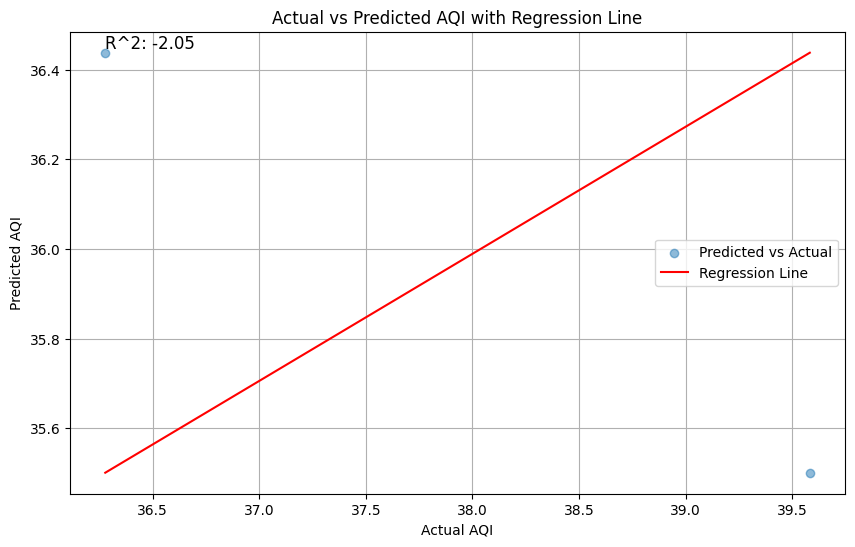

In [12]:

# Visualization
plt.figure(figsize=(10, 6))  # Set the figure size for better readability
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicted vs Actual')  # Add alpha for transparency

# Plotting the regression line
line_start = y_test.min()
line_end = y_test.max()
plt.plot([line_start, line_end], [y_pred.min(), y_pred.max()], color='red', label='Regression Line')  # Regression line

plt.xlabel('Actual AQI')
plt.ylabel('Predicted AQI')
plt.title('Actual vs Predicted AQI with Regression Line')
plt.legend()  # Add a legend

# Adding more information
plt.text(line_start, y_pred.max(), f'R^2: {r2_score(y_test, y_pred):.2f}', fontsize=12, verticalalignment='bottom')
plt.grid(True)  # Add grid for better readability
# Model evaluation
print('Coefficients:', model.coef_)
print('Intercept:', model.intercept_)
print('Mean squared error (MSE): %.2f' % mean_squared_error(y_test, y_pred))
print('Coefficient of determination (R^2): %.2f' % r2_score(y_test, y_pred))

plt.show()

## Make a prediction

➡️ Assignment Tasks
- What would you predict the average AQI to be in the month of January?  

I expect that In January the AQI averages in around the 30's.


## OPTIONAL: Compare Air Quality

➡️ Assignment Tasks
- Download the data from a year 20 years prior, using this website: https://aqs.epa.gov/aqsweb/airdata/download_files.html#AQI
- Append the new data to the previous dataframe
- Use the year as a variable in your regression.  Is year a significant factor in predicting AQI?

In [ ]:
#import, append and create new model